<a href="https://colab.research.google.com/github/mervegb/micrograd/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [188]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [189]:
def f(x):
  return 3*x**2 - 4*x + 5

In [190]:
f(3.0)

20.0

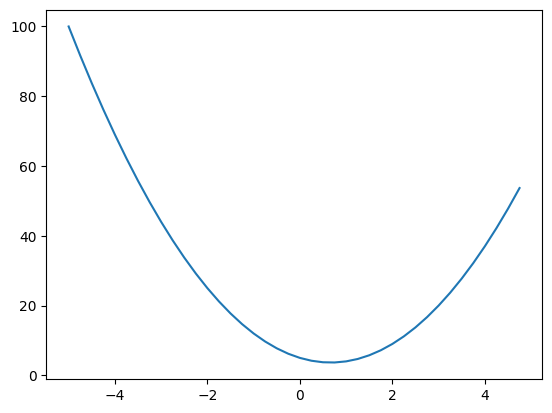

In [191]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [192]:
a = 2.0
b=-3.0
c=10.0
d = a*b +c
print(d)

4.0


In [193]:
h=0.001
a = 2.0
b=-3.0
c=10.0

d1 = a*b +c
c+=h
d2 = a*b +c

print("d1",d1)
print("d2",d2)
print("slope", (d2-d1)/h)

d1 4.0
d2 4.0009999999999994
slope 0.9999999999994458


In [194]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0,label='c')
e = a*b; e.label= 'e'
d = a*b + c; d.label='d'
f = Value(-2.0, label='f')
L = d *f; L.label='L'
L

Value(data=-8.0)

In [195]:
a = Value(2.0)
b = Value(4.0)
a-b

Value(data=-2.0)

In [196]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

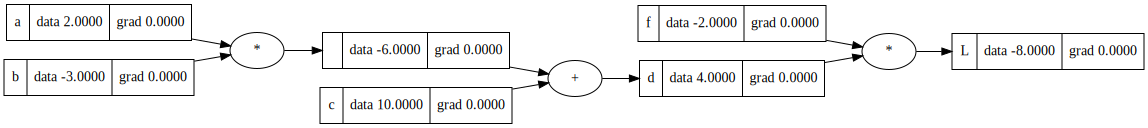

In [197]:
draw_dot(L)

In [198]:
L.grad = 1.0

#dl/dd
#(f(x+h)-f(x))/h
#((d+h)*f - d*f) /h
#(h*f)/h
#f

f.grad = 4.0
d.grad = -2

In [199]:
#dd/dc
#d = c + e
#(f(x+h) - f(x)) /h
#((c+h+e) - (c+e)) /h
#c+h+e-c-e
#h/h = 1.0

#Chain Rule
#dl / dc = (dl / dd) * (dd / dc)


#WANT dl/dc
#KNOW dd/dc
#dl/dc = (dl/dd) * (dd/dc)
c.grad = -2.0
e.grad = -2.0

In [200]:
#dl/de
#dl/da = (dl/de) * (de/da)
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

In [201]:
a.data += 0.01 * a .grad
b.data += 0.01 * b .grad
c.data += 0.01 * c .grad
f.data += 0.01 * f .grad

e = a*b
d=e+c
L=d*f
print(L.data)

-35.549696


In [202]:
def lol():
  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0,label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label='d'
  f = Value(-2.0, label='f')
  L = d *f; L.label='L'
  L1 = L.data


  a = Value(2.0+h, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0,label='c')
  e = a*b; e.label= 'e'
  d = e + c; d.label='d'
  d.data += h
  f = Value(-2.0, label='f')
  L = d *f; L.label='L'
  L2 = L.data


  print((L2-L1)/h)

lol()

#Backpropagation => recursive application of chain rule backwards through the computation graph


4.000000000000448


In [203]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#---
e = (2*n).exp()
o = (e-1) / (e+1)
#--
o.label = 'o'
o.backward()

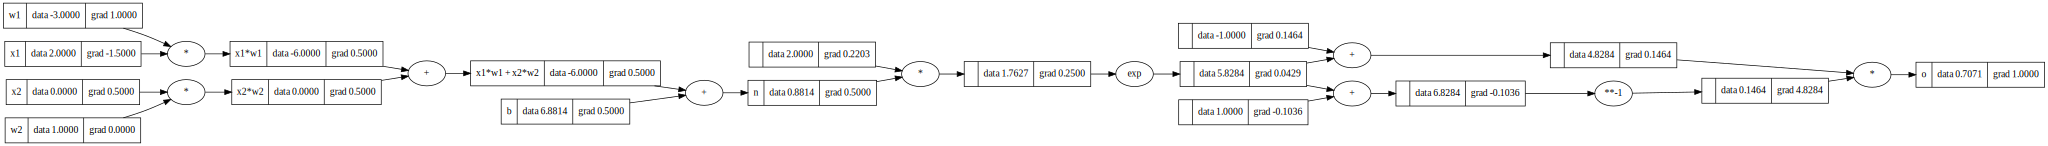

In [204]:
draw_dot(o)

In [205]:
o.backward()

In [206]:
o.grad = 1.0

In [207]:
#o = tanh(n)
#do / dn = 1 - tanh(n)**2
1- o.data**2

0.4999999999999998

In [208]:
n.grad = 0.5

In [209]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [210]:
x1w1.grad = 0.5
x2w2.grad =0.5

In [211]:
#x2w2 = x2 * w2 forward pass
#if you want to know how change in the weight w2 affects the output of this multiplication
# you want to find the gradient of the loss with respect to w2
x2.grad = w2.data * x2w2.grad

#this expression tells you how small change in the weight w2 will affect the final loss
w2.grad = x2.data * x2w2.grad

#x2.data => represents the value of x2, which is the derivative of the multiplication with respect to w2
#x2w2.grad => represents the derivative of loss with respect to output of multiplication
#w2.grad => overall derivative of the loss with respect to w2

In [212]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [213]:
#when you perform backpropagation, you start computing gradient of the loss function with respect to its inputs
o.grad = 1.0
o._backward()

In [214]:
n._backward()

In [215]:
b._backward()

In [216]:
x1w1x2w2._backward()

In [217]:
x2w2._backward()
x1w1._backward()

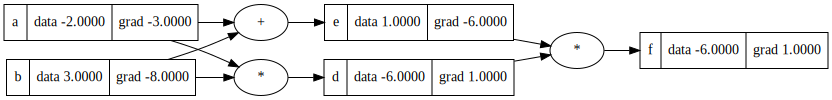

In [218]:
a = Value(-2, label='a')
b = Value(3.0, label='b')
d = a * b; d.label='d'
e = a + b; e.label='e'
f = d*e; f.label='f'

f.backward()
draw_dot(f)

In [219]:
import torch

In [220]:

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [221]:
o.item()

0.7071066904050358

In [222]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [223]:
from traitlets.traitlets import NoDefaultSpecified
import random

class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  #defines how neuron behaves when its called with an input x
  def __call__(self,x):
    #w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w,x)) , self.b)
    output = act.tanh() #activation function that squahes the output into range(-1,1)
    return output


class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  #Multi Layer Perceptron => aims to create a neural network made up of multiple layers
class MLP:
  def __init__(self,nin,nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x

x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=0.37150452253987704)

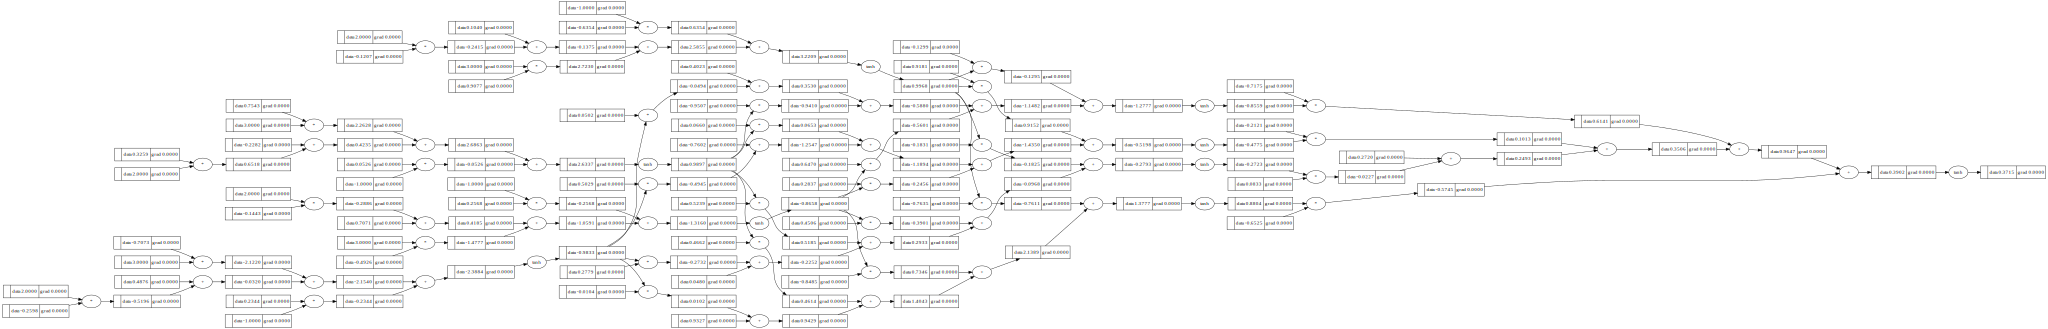

In [224]:
draw_dot(n(x))

In [225]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] #desired targets
ypred = [n(x) for x in xs]

ys
#Binary Classifier is a type of machine learning model that is tasked with categorizing elements into one of two possible groups
#These two classes are often labeled as 0 and 1


[1.0, -1.0, -1.0, 1.0]

In [226]:
#mean squared error loss
#calculates the sum of squared differences between ys & ypred
loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
loss

Value(data=2.214725198150915)

In [227]:
loss.backward()

In [228]:
n.layers[0].neurons[0].w[0].grad

-0.06630341879433488

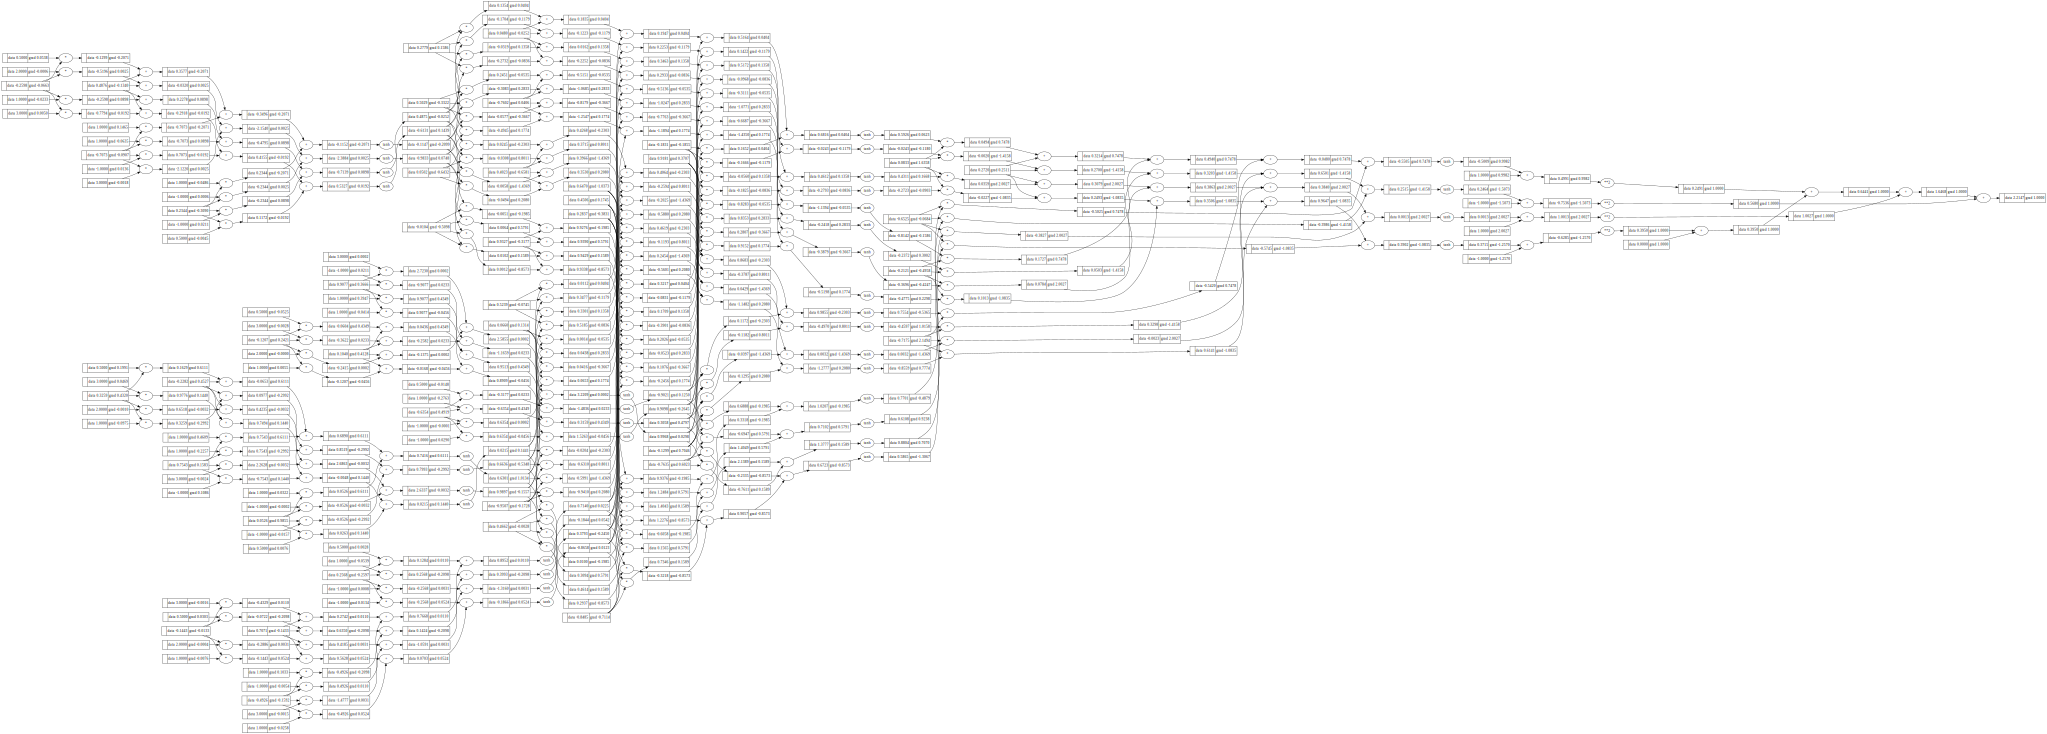

In [229]:
draw_dot(loss)